In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import os
from collections import defaultdict
import numpy as np
import re

GROLTS_LABELS = True

# Set the style
sns.set_theme(style="whitegrid")

# Set general plot parameters for Overleaf (1-column A4)
plt.rcParams.update({
    "figure.figsize": (3.3, 2.5),       # inches, ~1-column width
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "pdf.fonttype": 42,                 # vector fonts
    "ps.fonttype": 42
})

In [40]:
id_map = {
    0: 0,
    1: 1,
    2: 2,
    3: 5,
    4: 6,
    5: 7,
    6: 9,
    7: 10,
    8: 11,
    9: 12,
    10: 13,
    11: 13,
    12: 14,
    13: 14,
    14: 15,
    15: 16,
    16: 19,
    17: 20,
}

reverse_map = defaultdict(list)
for new_q, old_q in id_map.items():
    reverse_map[old_q].append(new_q)

In [47]:
# Function to replace sentences containing 'yes' or 'no' with 1 or 0
def replace_yes_no(sentence):
    if isinstance(sentence, str):  # Check if the value is a string
        if re.search(r'\b(yes)\b', sentence, re.IGNORECASE):
            return 1
        elif re.search(r'\b(no)\b', sentence, re.IGNORECASE):
            return 0
    return sentence 

def load_llm_accuracies(files, df_labels):
    """
    Returns:
    - old_acc_df: DataFrame indexed by old question_id, columns = model names
    - new_acc_df: DataFrame indexed by new question_id, columns = model names
    """
    old_data = {}
    new_data = {}

    for f in files:
        df = pd.read_csv(f)
        df['answer'] = df['answer'].apply(replace_yes_no)
        filename = os.path.basename(f).replace('.csv', '')
        if df['question_id'].nunique() == 21:
            # Old checklist
            df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))
            df_merged['correct'] = (df_merged['answer_pred'] == df_merged['answer_true']).astype(int)
            acc = df_merged.groupby('question_id')['correct'].mean()
            old_data[filename] = acc
        elif df['question_id'].nunique() == 18:
            # New checklist
            new_acc = []
            for i, row in df.iterrows():
                new_q = row['question_id']
                old_q = id_map.get(new_q)
                if old_q is None:
                    continue
                label_rows = df_labels[df_labels['question_id'] == old_q]
                match = label_rows[label_rows['paper_id'] == row['paper_id']]
                if not match.empty:
                    correct = (row['answer'] == match['answer'].values[0])
                    new_acc.append({'question_id': new_q, 'correct': int(correct)})
            if new_acc:
                acc_df = pd.DataFrame(new_acc).groupby('question_id')['correct'].mean()
                new_data[filename] = acc_df

    old_acc_df = pd.DataFrame(old_data).sort_index()
    new_acc_df = pd.DataFrame(new_data).sort_index()
    return old_acc_df, new_acc_df

def plot_mapped_accuracy_heatmaps(old_acc_df, new_acc_df, id_map):
    # Sort for consistent mapping
    old_acc_df = old_acc_df.sort_index()
    new_acc_df = new_acc_df.sort_index()

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.1)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # --- Old checklist heatmap (with colorbar on the right) ---
    heat1 = sns.heatmap(
        old_acc_df,
        vmin=0, vmax=1,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar=False,
        ax=ax1,
        annot=True,
        annot_kws={"size": 14},
        fmt=".2f",
        
    )
    ax1.set_title("Old Checklist Accuracy")
    ax1.set_ylabel("Old Question ID")
    ax1.set_xlabel("LLM")
    ax1.set_yticks(np.arange(len(old_acc_df)) + 0.5)
    if GROLTS_LABELS:
        ax1.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16'], rotation=0)
    else:
        ax1.set_yticklabels(old_acc_df.index, rotation=0)
    ax1.set_xticklabels(old_acc_df.columns, rotation=45, ha='right')

    # --- New checklist heatmap ---
    sns.heatmap(
        new_acc_df,
        vmin=0, vmax=1,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar=True,
        ax=ax2,
        cbar_kws={"label": "Accuracy", "pad": 0.1},    
        annot=True,
        annot_kws={"size": 14},
        fmt=".2f",
    )
    ax2.set_title("New Checklist Accuracy")
    ax2.set_ylabel("New Question ID")
    ax2.set_xlabel("LLM")
    ax2.set_yticks(np.arange(len(new_acc_df)) + 0.5)
    if GROLTS_LABELS:
        ax2.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18'], rotation=0)
    else:
        ax2.set_yticklabels(new_acc_df.index, rotation=0)
    ax2.set_xticklabels(new_acc_df.columns, rotation=45, ha='right')
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y', which='both', length=0)
    ax2.yaxis.set_label_position("right")

    # --- Add connection lines ---
    old_index_to_pos = {qid: i for i, qid in enumerate(old_acc_df.index)}
    new_index_to_pos = {qid: i for i, qid in enumerate(new_acc_df.index)}

    x_right_old = len(old_acc_df.columns)
    x_left_new = 0

    for new_q, old_q in id_map.items():
        if old_q in old_index_to_pos and new_q in new_index_to_pos:
            old_y = old_index_to_pos[old_q] + 0.5
            new_y = new_index_to_pos[new_q] + 0.5
            con = ConnectionPatch(
                xyA=(x_right_old, old_y), coordsA=ax1.transData,
                xyB=(x_left_new, new_y), coordsB=ax2.transData,
                color="gray", lw=1.0, alpha=0.5
            )
            fig.add_artist(con)

    #plt.tight_layout()
    plt.savefig("comparison.pdf",bbox_inches='tight')
    plt.show()

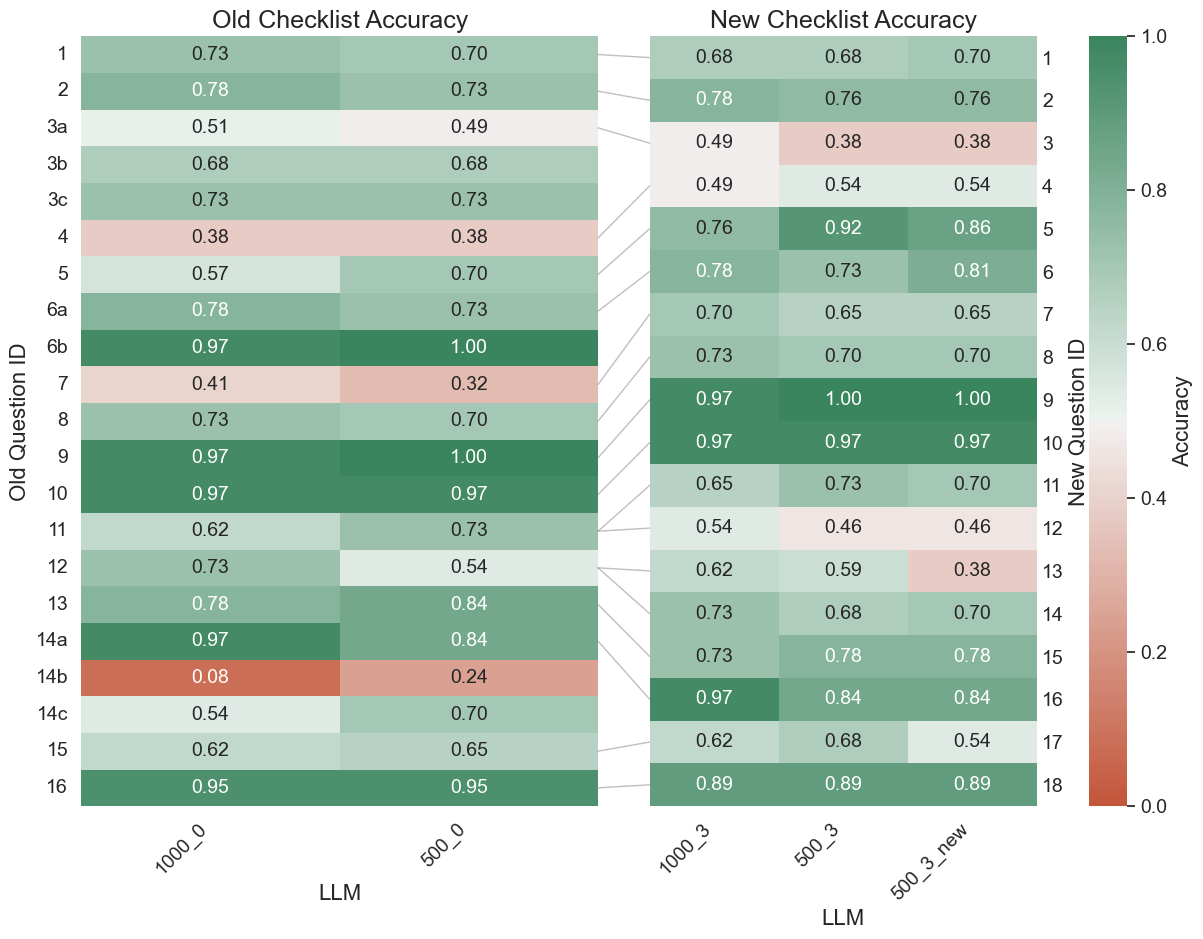

In [48]:
# Load labels
df_labels = pd.read_csv('./human_labels.csv', delimiter=';', dtype=int)
df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
df_labels['paper_id'] = df_labels['paper_id'].astype(int)
df_labels['question_id'] = df_labels['question_id'].astype(int)
df_labels['answer'] = df_labels['answer'].astype(int)

files = ["./outputs/1000_0.csv", "./outputs/500_0.csv", "./outputs/1000_3.csv", "./outputs/500_3.csv", "./outputs/500_3_new.csv"]

old_acc_df, new_acc_df = load_llm_accuracies(files, df_labels)
plot_mapped_accuracy_heatmaps(old_acc_df, new_acc_df, id_map)

In [173]:
display(old_acc_df.mean().sort_values(ascending=False))
display(new_acc_df.mean().sort_values(ascending=False))

500_0     0.696268
1000_0    0.691120
dtype: float64

1000_3       0.728228
500_3        0.720721
500_3_new    0.704204
dtype: float64

In [100]:
import glob
import os

#files = glob.glob('./outputs/*.csv')
files = ["./outputs/1000_0.csv", "./outputs/500_0.csv", "./outputs/1000_3.csv", "./outputs/500_3.csv", "./outputs/500_3_new.csv"]#["./outputs/1000_no_mm_output.csv", "./outputs/1000_mm_output.csv", "./outputs/500_no_mm_output.csv", "./outputs/0_no_mm_output.csv", "./outputs/500_mm_output.csv", "./outputs/1000_0.csv", "./outputs/500_0.csv", "./outputs/1000_3.csv", "./outputs/500_3.csv"]

In [101]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import numpy as np
import re

pd.set_option('future.no_silent_downcasting', True)

path = './outputs/'

# Single Eval

Summed Acc:  14.513513513513512


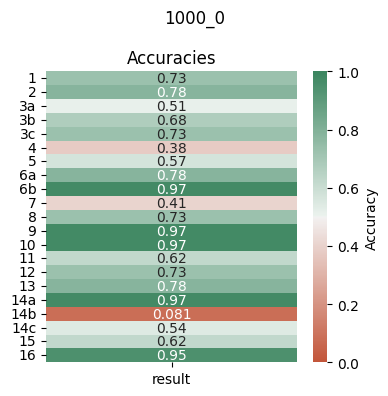

Summed Acc:  14.621621621621623


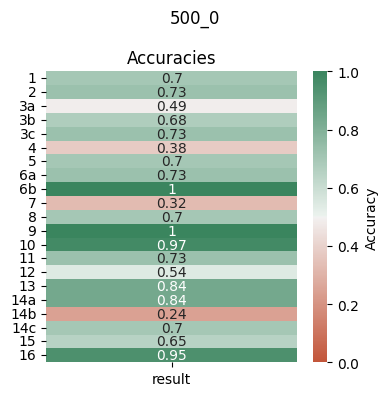

Summed Acc:  13.108108108108107


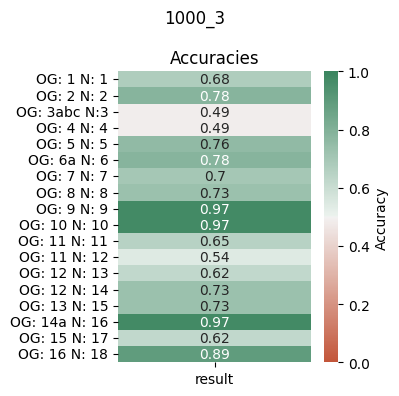

Summed Acc:  12.97297297297297


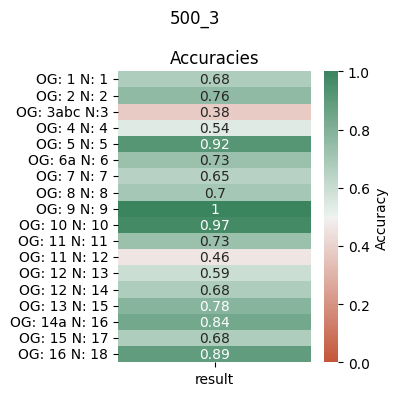

Summed Acc:  12.675675675675675


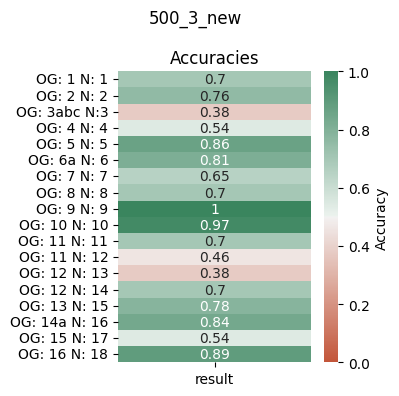

In [103]:
all_accs = {}
norm_accs = {}
for f in files:
    filename = os.path.basename(f).strip('.csv')
    # Read the data
    df = pd.read_csv(f)
    df_labels = pd.read_csv('./human_labels.csv', delimiter=';', dtype=int)
    df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
    df_labels['paper_id'] = df_labels['paper_id'].astype(int)
    df_labels['question_id'] = df_labels['question_id'].astype(int)
    df_labels['answer'] = df_labels['answer'].astype(int)

    # Replace 'YES'/'NO' answers with 1/0 in both DataFrames
    #df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
    df['answer'] = df['answer'].apply(replace_yes_no)

    if df['question_id'].nunique() == 18:
        df['question_id_old'] = df['question_id'].map(id_map).fillna(df['question_id'])
        df_labels['question_id_old'] = df_labels['question_id']
        df_merged = df.merge(df_labels, on=['paper_id', 'question_id_old'], suffixes=('_pred', '_true'))
        df_merged.rename(columns={'question_id_pred': 'question_id'}, inplace=True)
    else:  
        # Merge the prediction and label DataFrames on 'paper_id' and 'question_id'
        df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))

    # Add a 'result' column indicating whether the prediction matches the true label
    df_merged['result'] = np.where(
        df_merged['answer_pred'].isin([0, 1]),
        df_merged['answer_pred'] == df_merged['answer_true'],
        np.nan
    )

    # Group by 'question_id' to calculate the mean accuracy per question
    percent_true_by_question = df_merged.groupby('question_id')['result'].mean().reset_index()

    # Print the summed accuracy
    print('Summed Acc: ', percent_true_by_question['result'].sum())

    all_accs[filename] = percent_true_by_question['result'].sum()
    norm_accs[filename] = percent_true_by_question['result'].mean()

    # Plotting
    if GROUND_TRUTH_PLOT:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, ax1 = plt.subplots(figsize=(4, 4))

    # Heatmap for predicted results
    g = sns.heatmap(
        percent_true_by_question.set_index('question_id'),
        annot=True,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1, ax=ax1
    )
    g.set_title('Accuracies')
    g.set_xlabel('')
    g.set_ylabel('')
    if df['question_id'].nunique() == 18:
        g.set_yticklabels(['OG: 1 N: 1', 'OG: 2 N: 2', 'OG: 3abc N:3', 'OG: 4 N: 4', 'OG: 5 N: 5', 'OG: 6a N: 6', 'OG: 7 N: 7', 'OG: 8 N: 8', 'OG: 9 N: 9', 'OG: 10 N: 10', 'OG: 11 N: 11', 'OG: 11 N: 12', 'OG: 12 N: 13', 'OG: 12 N: 14', 'OG: 13 N: 15', 'OG: 14a N: 16', 'OG: 15 N: 17', 'OG: 16 N: 18']) 
    else:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    # Final plot adjustments
    fig.suptitle(filename)
    fig.tight_layout()
    plt.savefig('../viz/' + filename + '.pdf', bbox_inches='tight')
    plt.show()

In [104]:
all_accs = dict(sorted(all_accs.items(), key=lambda item: item[1], reverse=True))
norm_accs = dict(sorted(norm_accs.items(), key=lambda item: item[1], reverse=True))

In [105]:
norm_accs

{'1000_3': np.float64(0.7282282282282282),
 '500_3': np.float64(0.7207207207207206),
 '500_3_new': np.float64(0.7042042042042042),
 '500_0': np.float64(0.6962676962676964),
 '1000_0': np.float64(0.6911196911196911)}

IFF 2 papers:
- 1 proof that question formulation is important
- 2 use this proof to change grolts paper + best model

- Paper 2: can an llm be used to improve phrasing of survey questions, and in turn help answer these improved survey questions.

BUT 1 larger paper can be a good fit
- We do need an additional survey
- Additional idea, instead of just PTSD, we can use surveys on several other applications (drug abuse/youth delinquents)
- We start drafting an outline, not worry about length and find a good venue later
- This could be chapter 4 in Timo's PhD for example
- Authorship t.b.d.

In [106]:
all_accs

{'500_0': np.float64(14.621621621621623),
 '1000_0': np.float64(14.513513513513512),
 '1000_3': np.float64(13.108108108108107),
 '500_3': np.float64(12.97297297297297),
 '500_3_new': np.float64(12.675675675675675)}

In [107]:
# Read the data
df = pd.read_csv(path + filename + experiment + '.csv')
df_labels = pd.read_csv('./human_labels.csv', delimiter=';', dtype=int)
df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
df_labels['paper_id'] = df_labels['paper_id'].astype(int)
df_labels['question_id'] = df_labels['question_id'].astype(int)
df_labels['answer'] = df_labels['answer'].astype(int)

# Replace 'YES'/'NO' answers with 1/0 in both DataFrames
#df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
df['answer'] = df['answer'].apply(replace_yes_no)

# Merge the prediction and label DataFrames on 'paper_id' and 'question_id'
df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))

# Add a 'result' column indicating whether the prediction matches the true label
df_merged['result'] = np.where(
    df_merged['answer_pred'].isin([0, 1]),
    df_merged['answer_pred'] == df_merged['answer_true'],
    np.nan
)
print(len(df_merged))
df_nan = df_merged[df_merged.isna().any(axis=1)]
for row in df_nan.iterrows():
    print(row)
df_merged.dropna(inplace=True)
print(len(df_merged))

# Group by 'question_id' to calculate the mean accuracy per question
percent_true_by_question = df_merged.groupby('question_id')['result'].mean().reset_index()

# Print the summed accuracy
print('Summed Acc: ', percent_true_by_question['result'].sum())

# Plotting
if GROUND_TRUTH_PLOT:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
else:
    fig, ax1 = plt.subplots(figsize=(4, 4))

# Heatmap for predicted results
g = sns.heatmap(
    percent_true_by_question.set_index('question_id'),
    annot=True,
    cmap=sns.diverging_palette(20, 145, as_cmap=True),
    cbar_kws={'label': 'Accuracy'},
    vmin=0, vmax=1, ax=ax1
)
g.set_title('Accuracies')
g.set_xlabel('')
g.set_ylabel('')
if GROLTS_LABELS:
    g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

if GROUND_TRUTH_PLOT:
    percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    percent_true_by_question_lab = percent_true_by_question_lab.reindex(percent_true_by_question.index)
    
    # Heatmap for ground truth results
    g = sns.heatmap(
        percent_true_by_question_lab.set_index('question_id'),
        annot=True,
        cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1, ax=ax2
    )
    g.set_title('Ground Truth Mean')
    g.set_xlabel('')
    g.set_ylabel('')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax2.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Final plot adjustments
fig.suptitle(filename)
fig.tight_layout()
plt.savefig('../viz/' + filename + '.pdf', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './outputs/500_3_new_0.csv'

# Question set comparison

In [ ]:
if os.path.exists(path + filename + '-p1.csv') and os.path.exists(path + filename + '-p2.csv') and os.path.exists(path + filename + '-p3.csv'):
    df1 = pd.read_csv(path + filename + '-p1.csv')
    df1['experiment'] = 'p1'
    df2 = pd.read_csv(path + filename + '-p2.csv')
    df2['experiment'] = 'p2'
    df3 = pd.read_csv(path + filename + '-p3.csv')
    df3['experiment'] = 'p3'
    
    # Combine the data
    df = pd.concat([df1, df2, df3])
    
    # Replace categorical 'YES'/'NO' with numeric 1/0
    df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
    
    # Load human labels
    df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
    df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
    df_labels['paper_id'] = df_labels['paper_id'].astype(int)
    df_labels['question_id'] = df_labels['question_id'].astype(int)
    df_labels['answer'] = df_labels['answer'].astype(int)
    
    # Merge predictions with true labels
    df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))
    
    # Add a 'result' column indicating whether the prediction matches the true label
    df_merged['result'] = np.where(
        df_merged['answer_pred'].isin([0, 1]),
        df_merged['answer_pred'] == df_merged['answer_true'],
        np.nan
    )
    df_merged.dropna(inplace=True)
    
    # Calculate accuracy by question and experiment
    accuracy_by_question_exp = df_merged.groupby(['question_id', 'experiment'])['result'].mean().reset_index()
    
    # Calculate the best accuracy for each question
    accuracy_by_question_exp['is_best'] = accuracy_by_question_exp.groupby('question_id')['result'].transform(
        lambda x: x == x.max()
    )

    # Pivot the data for heatmap
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    pivot_is_best = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='is_best')

    print("Sum of best values:", accuracy_by_question_exp.loc[accuracy_by_question_exp['is_best']].groupby('question_id')['result'].first().sum())

    # Heatmap with best values highlighted
    fig, ax1 = plt.subplots(figsize=(6, 4))
    cmap = sns.diverging_palette(20, 145, as_cmap=True)

    # Annotate best values
    def highlight_best(data, is_best):
        for i in range(data.shape[0]):  # Row indices
            for j in range(data.shape[1]):  # Column indices
                if is_best.iloc[i, j]:  # Check if it's the best
                    ax1.text(
                        j + 0.5, i + 0.5,  # Text position (center of the cell)
                        f"{data.iloc[i, j]:.2f}",  # Annotated value
                        ha='center', va='center',
                        color='black'
                    )

    # Draw heatmap
    sns.heatmap(
        pivot_accuracy,
        annot=False,  # Disable default annotations
        cmap=cmap,
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )

    # Add highlights
    highlight_best(pivot_accuracy, pivot_is_best)

    # Configure plot
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('Experiment')
    ax1.set_ylabel('Question ID')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    if GROLTS_LABELS:
        ax1.set_yticklabels([
            '1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10',
            '11', '12', '13', '14a', '14b', '14c', '15', '16'
        ])

    # Plotting
    if GROUND_TRUTH_PLOT:
        fig = plt.figure(figsize=(11.69, 5))
        gs = GridSpec(1, 2, width_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
    else:
        fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Heatmap for predictions accuracy by question and experiment
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    g = sns.heatmap(
        pivot_accuracy,
        annot=True,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('')
    ax1.set_ylabel('Question ID')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    if GROUND_TRUTH_PLOT:
        # Prepare the true labels data for comparison
        percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    
        # Heatmap for ground truth mean accuracy by question
        g = sns.heatmap(
            percent_true_by_question_lab.set_index('question_id'),
            annot=True,
            cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
            cbar_kws={'label': 'Percentage True'},
            vmin=0, vmax=1,
            ax=ax2
        )
        ax2.set_title('Ground Truth Mean')
        ax2.set_xlabel('')
        ax2.set_ylabel('Question ID')
        if GROLTS_LABELS:
            g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    
    # Final title and layout adjustment
    fig.suptitle(filename)
    fig.tight_layout()
    plt.savefig('../viz/questions-' + chunk_size + '-' + generator + '-' + embedder + '.pdf', bbox_inches='tight')
    plt.show()


# Context size comparison

In [ ]:
if os.path.exists(path + '500-' + generator + '-' + embedder + experiment + '.csv') and os.path.exists(path + '1000-' + generator + '-' + embedder + experiment + '.csv') and os.path.exists(path + '2000-' + generator + '-' + embedder + experiment + '.csv'):
    df1 = pd.read_csv(path + '500-' + generator + '-' + embedder + experiment + '.csv')
    df1['experiment'] = '1500'
    df2 = pd.read_csv(path + '1000-' + generator + '-' + embedder + experiment + '.csv')
    df2['experiment'] = '5000'
    df3 = pd.read_csv(path + '2000-' + generator + '-' + embedder + experiment + '.csv')
    df3['experiment'] = '10000'
    
    # Combine the data
    df = pd.concat([df1, df2, df3])
    
    # Replace categorical 'YES'/'NO' with numeric 1/0
    df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
    
    # Load human labels
    df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
    df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
    df_labels['paper_id'] = df_labels['paper_id'].astype(int)
    df_labels['question_id'] = df_labels['question_id'].astype(int)
    df_labels['answer'] = df_labels['answer'].astype(int)
    
    # Merge predictions with true labels
    df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))
    
    # Add a 'result' column indicating whether the prediction matches the true label
    df_merged['result'] = np.where(
        df_merged['answer_pred'].isin([0, 1]),
        df_merged['answer_pred'] == df_merged['answer_true'],
        np.nan
    )
    df_merged.dropna(inplace=True)
    
    # Calculate accuracy by question and experiment
    accuracy_by_question_exp = df_merged.groupby(['question_id', 'experiment'])['result'].mean().reset_index()
    
    # Plotting
    if GROUND_TRUTH_PLOT:
        fig = plt.figure(figsize=(11.69, 5))
        gs = GridSpec(1, 2, width_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
    else:
        fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Heatmap for predictions accuracy by question and experiment
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    g = sns.heatmap(
        pivot_accuracy,
        annot=True,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('')
    ax1.set_ylabel('Question ID')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    if GROUND_TRUTH_PLOT:
        # Prepare the true labels data for comparison
        percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    
        # Heatmap for ground truth mean accuracy by question
        g = sns.heatmap(
            percent_true_by_question_lab.set_index('question_id'),
            annot=True,
            cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
            cbar_kws={'label': 'Percentage True'},
            vmin=0, vmax=1,
            ax=ax2
        )
        ax2.set_title('Ground Truth Mean')
        ax2.set_xlabel('')
        ax2.set_ylabel('Question ID')
        if GROLTS_LABELS:
            g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    
    # Final title and layout adjustment
    fig.suptitle(filename)
    fig.tight_layout()
    plt.savefig('../viz/contexts-' + generator + '-' + embedder + experiment + '.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data_out/500-microsoft-phi-4-text-embedding-3-large-p3.csv")
df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)

df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
df_labels['paper_id'] = df_labels['paper_id'].astype(int)
df_labels['question_id'] = df_labels['question_id'].astype(int)
df_labels['answer'] = df_labels['answer'].astype(int)

df_labels = df_labels[df_labels["question_id"] == 19]

df = df[df["question_id"] == 19]

# Merge predictions with true labels
df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))

# Add a 'result' column indicating whether the prediction matches the true label
df_merged['result'] = np.where(
    df_merged['answer_pred'].isin([0, 1]),
    df_merged['answer_pred'] == df_merged['answer_true'],
    np.nan
)

FileNotFoundError: [Errno 2] No such file or directory: './data_out/500-microsoft-phi-4-text-embedding-3-large-p3.csv'

In [ ]:
df_merged[df_merged["result"] == 0].to_csv("500-phi-4-3-large-p3-q19.csv")